##### Copyright 2023 The TF-Agents Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Checkpointer and PolicySaver

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

`tf_agents.utils.common.Checkpointer` is a utility to save/load the training state, policy state, and replay_buffer state to/from a local storage.

`tf_agents.policies.policy_saver.PolicySaver` is a tool to save/load only the policy, and is lighter than `Checkpointer`. You can use `PolicySaver` to deploy the model as well without any knowledge of the code that created the policy.

In this tutorial, we will use DQN to train a model, then use `Checkpointer` and `PolicySaver` to show how we can store and load the states and model in an interactive way. Note that we will use TF2.0's new saved_model tooling and format for `PolicySaver`.


## Setup

 If you haven't installed the following dependencies, run:

In [2]:
#@test {"skip": true}
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg python-opengl
!pip install pyglet
!pip install 'imageio==2.4.0'
!pip install 'xvfbwrapper==0.2.9'
!pip install tf-agents[reverb]

Hit:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
0% [Connecting to security.ubuntu.com (91.189.91.39)] [Connecting to developer.

Hit:5 https://download.docker.com/linux/ubuntu focal InRelease
Hit:6 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease
Hit:7 https://nvidia.github.io/nvidia-container-runtime/stable/ubuntu18.04/amd64  InRelease
Hit:8 https://nvidia.github.io/nvidia-docker/ubuntu18.04/amd64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://apt.llvm.org/focal llvm-toolchain-focal-14 InRelease
Hit:10 http://security.ubuntu.com/ubuntu focal-security InRelease
0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Waiting for headers]

Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Waiting for headers]

Hit:12 http://ppa.launchpad.net/longsleep/golang-backports/ubuntu focal InRelease
0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Waiting for headers]

0% [Waiting for headers]

Hit:13 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu focal InRelease
0% [Working]

0% [Working]

0% [Working]

0% [Working]

0% [Working]

0% [Working]

0% [Working]

Fetched 108 kB in 1s (82.8 kB/s)


python-opengl is already the newest version (3.1.0+dfsg-2build1).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.6).


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0 libxmlb2
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


  Using cached imageio-2.4.0-py3-none-any.whl


  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.1
    Uninstalling imageio-2.25.1:
      Successfully uninstalled imageio-2.25.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.3 requires imageio>=2.4.1, but you have imageio 2.4.0 which is incompatible.


  Using cached tf_agents-0.15.0-py3-none-any.whl (1.4 MB)


  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)


  Using cached gym-0.23.0-py3-none-any.whl


  Using cached pygame-2.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


  Using cached tensorflow_probability-0.19.0-py2.py3-none-any.whl (6.7 MB)


  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)


  Using cached tensorflow-2.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)


  Using cached rlds-0.1.7-py3-none-manylinux2010_x86_64.whl (48 kB)


  Using cached dm_reverb-0.10.0-cp39-cp39-manylinux2014_x86_64.whl (6.3 MB)


  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)


  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)


  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)


  Using cached portpicker-1.5.2-py3-none-any.whl (14 kB)


  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)


  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0rc0


    Uninstalling tensorflow-estimator-2.12.0rc0:
      Successfully uninstalled tensorflow-estimator-2.12.0rc0


  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3


    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


  Attempting uninstall: keras
    Found existing installation: keras 2.12.0rc0


    Uninstalling keras-2.12.0rc0:
      Successfully uninstalled keras-2.12.0rc0


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0


    Uninstalling tensorboard-2.12.0:
      Successfully uninstalled tensorboard-2.12.0


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0rc0


    Uninstalling tensorflow-2.12.0rc0:


      Successfully uninstalled tensorflow-2.12.0rc0


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import io
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import tensorflow as tf
import zipfile
import IPython

try:
  from google.colab import files
except ImportError:
  files = None
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

2023-02-16 13:54:26.301850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-16 13:54:26.301938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-16 13:54:26.301947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
#@test {"skip": true}
# Set up a virtual display for rendering OpenAI gym environments.
import xvfbwrapper
xvfbwrapper.Xvfb(1400, 900, 24).start()

## DQN agent
We are going to set up DQN agent, just like in the previous colab. The details are hidden by default as they are not core part of this colab, but you can click on 'SHOW CODE' to see the details.

### Hyperparameters

In [5]:
env_name = "CartPole-v1"

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 1e-3
log_interval = 5

num_eval_episodes = 10
eval_interval = 1000

### Environment

In [6]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent

In [7]:
#@title
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step)
agent.initialize()

### Data Collection

In [8]:
#@title
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Train the agent

In [9]:
#@title
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

def train_one_iteration():

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  iteration = agent.train_step_counter.numpy()
  print ('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

### Video Generation

In [10]:
#@title
def embed_gif(gif_buffer):
  """Embeds a gif file in the notebook."""
  tag = '<img src="data:image/gif;base64,{0}"/>'.format(base64.b64encode(gif_buffer).decode())
  return IPython.display.HTML(tag)

def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
  num_episodes = 3
  frames = []
  for _ in range(num_episodes):
    time_step = eval_tf_env.reset()
    frames.append(eval_py_env.render())
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = eval_tf_env.step(action_step.action)
      frames.append(eval_py_env.render())
  gif_file = io.BytesIO()
  imageio.mimsave(gif_file, frames, format='gif', fps=60)
  IPython.display.display(embed_gif(gif_file.getvalue()))

### Generate a video
Check the performance of the policy by generating a video.

global_step:
<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>



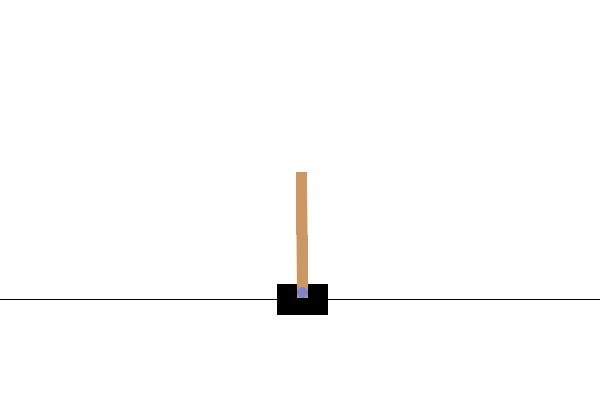

In [11]:
print ('global_step:')
print (global_step)
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env)

## Setup Checkpointer and PolicySaver

Now we are ready to use Checkpointer and PolicySaver.

### Checkpointer


In [12]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

### Policy Saver

In [13]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

### Train one iteration

In [14]:
#@test {"skip": true}
print('Training one iteration....')
train_one_iteration()

Training one iteration....


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


iteration: 1 loss: 1.0018746852874756


### Save to checkpoint

In [15]:
train_checkpointer.save(global_step)

### Restore checkpoint

For this to work, the whole set of objects should be recreated the same way as when the checkpoint was created.

In [16]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

Also save policy and export to a location

In [17]:
tf_policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: /tmpfs/tmp/policy/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /tmpfs/tmp/policy/assets


The policy can be loaded without having any knowledge of what agent or network was used to create it. This makes deployment of the policy much easier.

Load the saved policy and check how it performs


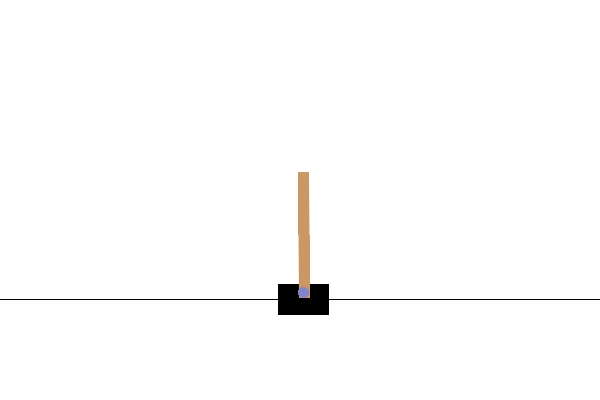

In [18]:
saved_policy = tf.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

## Export and import
The rest of the colab will help you export / import checkpointer and policy directories such that you can continue training at a later point and deploy the model without having to train again.

Now you can go back to 'Train one iteration' and train a few more times such that you can understand the difference later on. Once you start to see slightly better results, continue below.

In [19]:
#@title Create zip file and upload zip file (double-click to see the code)
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

Create a zipped file from the checkpoint directory.

In [20]:
train_checkpointer.save(global_step)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

Download the zip file.

In [21]:
#@test {"skip": true}
if files is not None:
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

After training for some time (10-15 times), download the checkpoint zip file,
and go to "Runtime > Restart and run all" to reset the training,
and come back to this cell. Now you can upload the downloaded zip file,
and continue the training.

In [22]:
#@test {"skip": true}
upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

Once you have uploaded checkpoint directory, go back to 'Train one iteration' to continue training or go back to 'Generate a video' to check the performance of the loaded policy.

Alternatively, you can save the policy (model) and restore it.
Unlike checkpointer, you cannot continue with the training, but you can still deploy the model. Note that the downloaded file is much smaller than that of the checkpointer.

In [23]:
tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))

INFO:tensorflow:Assets written to: /tmpfs/tmp/policy/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /tmpfs/tmp/policy/assets


In [24]:
#@test {"skip": true}
if files is not None:
  files.download(policy_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

Upload the downloaded policy directory (exported_policy.zip) and check how the saved policy performs.


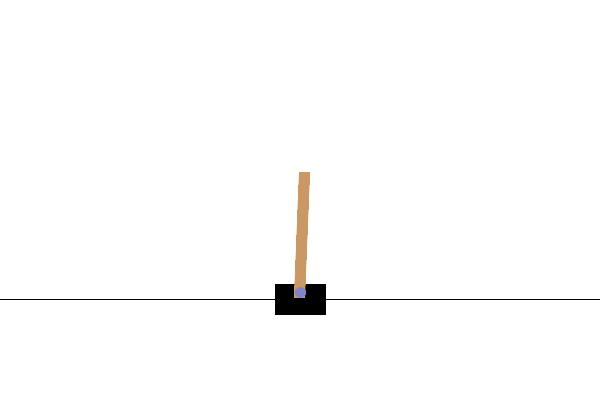

In [25]:
#@test {"skip": true}
upload_and_unzip_file_to(policy_dir)
saved_policy = tf.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)


## SavedModelPyTFEagerPolicy

If you don't want to use TF policy, then you can also use the saved_model directly with the Python env through the use of `py_tf_eager_policy.SavedModelPyTFEagerPolicy`.

Note that this only works when eager mode is enabled.


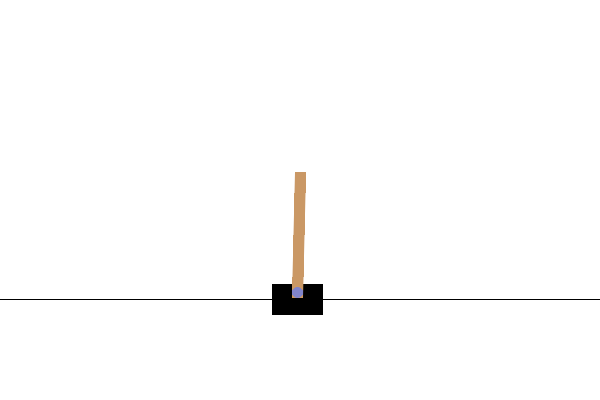

In [26]:
eager_py_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    policy_dir, eval_py_env.time_step_spec(), eval_py_env.action_spec())

# Note that we're passing eval_py_env not eval_env.
run_episodes_and_create_video(eager_py_policy, eval_py_env, eval_py_env)

## Convert policy to TFLite

See [TensorFlow Lite converter](https://www.tensorflow.org/lite/convert) for more details.

In [27]:
converter = tf.lite.TFLiteConverter.from_saved_model(policy_dir, signature_keys=["action"])
tflite_policy = converter.convert()
with open(os.path.join(tempdir, 'policy.tflite'), 'wb') as f:
  f.write(tflite_policy)

2023-02-16 13:55:00.103245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-16 13:55:00.103277: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


### Run inference on TFLite model

See [TensorFlow Lite Inference](https://tensorflow.org/lite/guide/inference) for more details.

In [28]:
import numpy as np
interpreter = tf.lite.Interpreter(os.path.join(tempdir, 'policy.tflite'))

policy_runner = interpreter.get_signature_runner()
print(policy_runner._inputs)

{'0/discount': 1, '0/observation': 2, '0/reward': 3, '0/step_type': 0}


In [29]:
policy_runner(**{
    '0/discount':tf.constant(0.0),
    '0/observation':tf.zeros([1,4]),
    '0/reward':tf.constant(0.0),
    '0/step_type':tf.constant(0)})

{'action': array([0])}